# Localize anatomic structures

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from PIL import Image
import os
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='runs/anatomy_detector')


/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-20 13:37:07.353879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 13:37:07.369091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate co

## Step 1: load dataset

In [2]:
annotation_path = "../dataset/ObjectDetection.xlsx"
dataset_dir = "../training_set/"
df = pd.read_excel("../dataset/ObjectDetection.xlsx")
annotations = defaultdict(list)

structures = sorted(set(df['structure']))  # or predefined list
structure_to_id = {name: i for i, name in enumerate(structures)}
K = len(structure_to_id)  # should be 9

for _, row in df.iterrows():
    fname = row['fname']
    class_id = structure_to_id[row['structure']]
    
    hmin, wmin, hmax, wmax = row['h_min'], row['w_min'], row['h_max'], row['w_max']
    box = (wmin, hmin, wmax, hmax)  # (xmin, ymin, xmax, ymax)
    annotations[fname].append((class_id, box))

annotations['168.png']

[(8, (171, 178, 261, 244)),
 (4, (308, 96, 349, 111)),
 (7, (300, 133, 408, 205)),
 (5, (324, 86, 349, 95)),
 (6, (345, 79, 376, 89)),
 (3, (173, 247, 231, 328)),
 (2, (257, 385, 464, 418)),
 (1, (213, 301, 290, 328)),
 (0, (216, 345, 304, 367))]

In [3]:
print(structure_to_id)
id_to_structure = {v: k for k, v in structure_to_id.items()}
print(id_to_structure)

{'CM': 0, 'IT': 1, 'NT': 2, 'midbrain': 3, 'nasal bone': 4, 'nasal skin': 5, 'nasal tip': 6, 'palate': 7, 'thalami': 8}
{0: 'CM', 1: 'IT', 2: 'NT', 3: 'midbrain', 4: 'nasal bone', 5: 'nasal skin', 6: 'nasal tip', 7: 'palate', 8: 'thalami'}


In [4]:
bbox_params = A.BboxParams(
    format='pascal_voc',      # (x_min, y_min, x_max, y_max)
    label_fields=['class_labels'],  # required, even if you're not using labels
    min_area=0,
    min_visibility=0.0
)

TARGET_HEIGHT = 400 
TARGET_WIDTH = 600

train_transforms = A.Compose([
    A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['class_labels']
))

val_transforms = A.Compose([
    A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH, p=1.0),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['class_labels']
))

In [5]:
class AnatomyDataset(Dataset):
    def __init__(self, img_dir, annotations, structure_to_id, albu_transform=train_transforms):
        self.img_dir = img_dir
        self.annotations = annotations
        self.structure_to_id = structure_to_id
        self.img_names = sorted(os.listdir(img_dir))
        self.K = len(structure_to_id)
        self.transform = None
        self.albu_transform = albu_transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        fname = self.img_names[idx]
        img_path = os.path.join(self.img_dir, fname)
        image = np.array(Image.open(img_path).convert('L'))  # shape [H, W]

        # Prepare annotations
        boxes_list = []
        labels_list = []
        for class_id, (xmin, ymin, xmax, ymax) in self.annotations[fname]:
            boxes_list.append([xmin, ymin, xmax, ymax])
            labels_list.append(class_id)

        # Albumentations expects boxes as List[List[float]], not Tensor
        transformed = self.albu_transform(
            image=image,
            bboxes=boxes_list,
            class_labels=labels_list
        )

        image_tensor = transformed['image']  # [1, H, W]
        boxes_aug = transformed['bboxes']   # list of [x_min, y_min, x_max, y_max]
        labels_aug = transformed['class_labels']

        # Create output tensors
        class_mask = torch.zeros(self.K)
        box_tensor = torch.zeros((self.K, 4))

        H, W = image_tensor.shape[1:]  # new dimensions after transform

        for class_id, (xmin, ymin, xmax, ymax) in zip(labels_aug, boxes_aug):
            cx = ((xmin + xmax) / 2) / W
            cy = ((ymin + ymax) / 2) / H
            bw = (xmax - xmin) / W
            bh = (ymax - ymin) / H

            class_mask[int(class_id)] = 1
            box_tensor[int(class_id)] = torch.tensor([cx, cy, bw, bh])

        return image_tensor, class_mask, box_tensor


In [6]:
class AnatomySubset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
        # Copy important attributes
        self.img_names = [dataset.img_names[i] for i in indices]
        self.K = dataset.K
        
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]
        
    def __len__(self):
        return len(self.indices)

## Step 2: Model definition

In [7]:
class DetectionHead(nn.Module):
    def __init__(self, in_features, num_classes=9):
        super().__init__()
        self.num_classes = num_classes
        
        # Classifier head: multi-label binary classification
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
        
        # Regressor head: 4 coords per class (x, y, w, h)
        self.regressor = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes * 4)
        )

    def forward(self, features):
        probs = self.classifier(features)       # [B, 9]
        boxes = self.regressor(features)        # [B, 36]
        boxes = boxes.view(-1, self.num_classes, 4)  # [B, 9, 4]
        return probs, boxes

In [8]:
class GrayscaleMobileNetDetector(nn.Module):
    def __init__(self, num_classes=9):
        super().__init__()
        # Load pretrained MobileNetV2 and adapt for 1 channel
        mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Modify first conv layer to accept grayscale
        first_conv = self.features[0][0]
        new_conv = nn.Conv2d(1, first_conv.out_channels, kernel_size=first_conv.kernel_size,
                             stride=first_conv.stride, padding=first_conv.padding, bias=False)
        new_conv.weight.data = first_conv.weight.data.mean(dim=1, keepdim=True)  # average RGB weights
        self.features[0][0] = new_conv

        # Head
        self.head = DetectionHead(in_features=1280, num_classes=num_classes)

    def forward(self, x):  # x: [B, 1, H, W]
        x = self.features(x)               # [B, 1280, H', W']
        x = self.pool(x).view(x.size(0), -1)  # [B, 1280]
        return self.head(x)


In [9]:
def detection_loss(pred_probs, pred_boxes, gt_probs, gt_boxes, lambda_reg=10.0):
    """
    pred_probs: [B, K] (sigmoid output)
    pred_boxes: [B, K, 4]
    gt_probs:   [B, K] (0 or 1)
    gt_boxes:   [B, K, 4]
    """
    bce = nn.BCELoss()
    cls_loss = bce(pred_probs, gt_probs)

    # Compute Smooth L1 per box, then sum over coordinates
    smooth_l1 = nn.SmoothL1Loss(reduction='none')
    box_loss = smooth_l1(pred_boxes, gt_boxes).sum(dim=-1)  # [B, K]

    # Gate with class presence * predicted confidence
    gated_loss = gt_probs * pred_probs.detach() * box_loss  # [B, K]
    reg_loss = gated_loss.mean()

    return cls_loss + lambda_reg * reg_loss


In [10]:
torch.cuda.empty_cache()

In [11]:
model = GrayscaleMobileNetDetector(num_classes=9)
model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

In [12]:
def detection_loss(pred_probs, pred_boxes, gt_probs, gt_boxes, lambda_reg=10.0):
    """
    pred_probs: [B, K] (sigmoid output)
    pred_boxes: [B, K, 4]
    gt_probs:   [B, K] (0 or 1)
    gt_boxes:   [B, K, 4]
    """
    bce = nn.BCELoss()
    cls_loss = bce(pred_probs, gt_probs)

    # Compute Smooth L1 per box, then sum over coordinates
    smooth_l1 = nn.SmoothL1Loss(reduction='none')
    box_loss = smooth_l1(pred_boxes, gt_boxes).sum(dim=-1)  # [B, K]

    # Gate with class presence * predicted confidence
    gated_loss = gt_probs * pred_probs.detach() * box_loss  # [B, K]
    reg_loss = gated_loss.mean()

    return cls_loss + lambda_reg * reg_loss



## Step 3: Train

In [13]:
# Split data
BATCH_SIZE = 8 
dataset = AnatomyDataset(
    img_dir=dataset_dir,
    annotations=annotations,
    structure_to_id=structure_to_id,
    albu_transform=train_transforms
)

# Calculate split sizes
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

# Generate random indices for splitting
indices = torch.randperm(dataset_size).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create your custom AnatomySubset instances
train_ds = AnatomySubset(dataset, train_indices)
val_ds = AnatomySubset(dataset, val_indices)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=3)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=3)

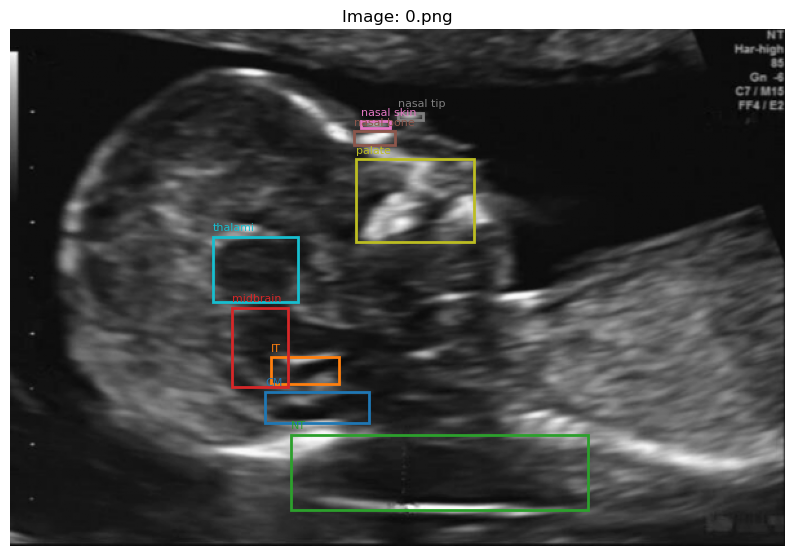

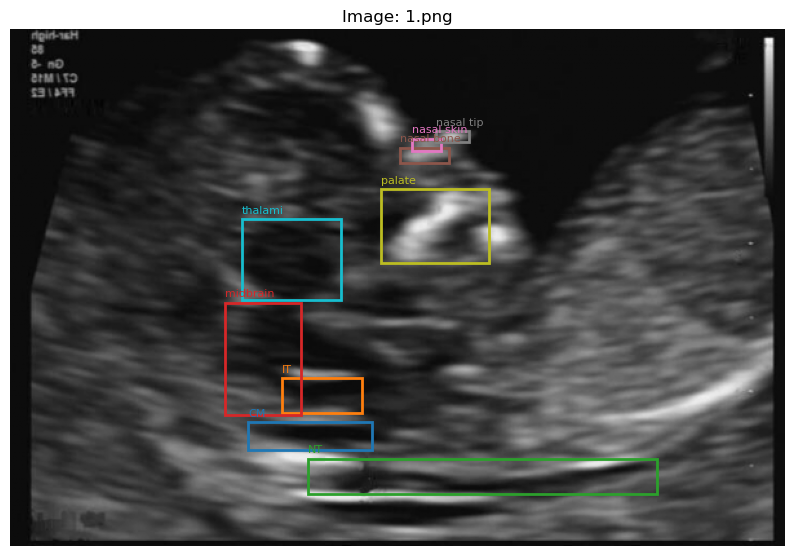

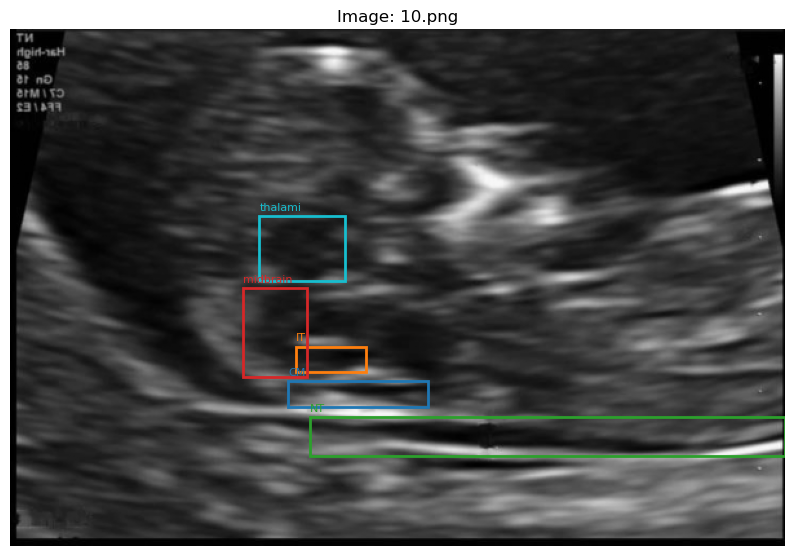

In [14]:
def visualize_sample(dataset, idx):
    colors = plt.get_cmap('tab10', len(structures))
    color_map = {structure: colors(i) for i, structure in enumerate(structures)}
    img, class_mask, boxes = dataset[idx]
    img_name = dataset.img_names[idx]
    
    # Convert tensor to numpy for plotting
    img_np = img.squeeze().numpy()
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np, cmap='gray')
    
    # Plot boxes for present classes
    present_classes = torch.where(class_mask == 1)[0]
    
    for class_idx in present_classes:
        structure_name = id_to_structure[class_idx.item()]
        color = color_map[structure_name]
        cx, cy, w, h = boxes[class_idx]
        
        # Convert normalized coordinates back to pixel coordinates
        cx_px = cx * TARGET_WIDTH
        cy_px = cy * TARGET_HEIGHT
        w_px = w * TARGET_WIDTH
        h_px = h * TARGET_HEIGHT
        
        # Convert center coordinates to top-left coordinates
        x = cx_px - w_px/2
        y = cy_px - h_px/2
        
        # Create rectangle patch
        rect = patches.Rectangle((x, y), w_px, h_px, linewidth=2, 
                               edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Get structure name
        ax.text(x, y-5, structure_name, color=color_map[structure_name], fontsize=8)
    
    plt.title(f'Image: {img_name}')
    plt.axis('off')
    plt.show()

# Visualize a few examples
for i in range(3):  # Show 3 examples
    visualize_sample(dataset, i)

In [15]:
def box_iou(box1, box2):
    # box1, box2: (cx, cy, w, h) in normalized [0, 1]
    box1 = box1.clone()
    box2 = box2.clone()

    x1_min = box1[0] - box1[2]/2
    y1_min = box1[1] - box1[3]/2
    x1_max = box1[0] + box1[2]/2
    y1_max = box1[1] + box1[3]/2

    x2_min = box2[0] - box2[2]/2
    y2_min = box2[1] - box2[3]/2
    x2_max = box2[0] + box2[2]/2
    y2_max = box2[1] + box2[3]/2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area

    return inter_area / union if union > 0 else 0.0

def compute_map_per_image(gt_mask, gt_boxes, pred_mask, pred_boxes, iou_thresh=0.5):
    aps = []
    for k in range(gt_mask.shape[0]):
        gt_present = gt_mask[k].item() == 1
        pred_present = pred_mask[k].item() > 0.5
        if gt_present and pred_present:
            iou = box_iou(gt_boxes[k], pred_boxes[k])
            aps.append(1.0 if iou >= iou_thresh else 0.0)
        elif not gt_present and not pred_present:
            continue  # true negative
        else:
            aps.append(0.0)  # either FN or FP
    return sum(aps) / len(aps) if aps else 0.0


In [16]:
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0

    for imgs, cls_mask, box_gt in tqdm(dataloader):
        imgs = imgs.cuda()
        cls_mask = cls_mask.cuda()
        box_gt = box_gt.cuda()

        optimizer.zero_grad()
        cls_pred, box_pred = model(imgs)

        loss = detection_loss(cls_pred, box_pred, cls_mask, box_gt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate(model, val_loader, epoch):
    model.eval()
    total_loss = 0
    total_map = 0
    with torch.no_grad():
        for imgs, class_mask, box_gt in val_loader:
            imgs = imgs.cuda()
            class_mask = class_mask.cuda()
            box_gt = box_gt.cuda()

            cls_pred, box_pred = model(imgs)
            loss = detection_loss(cls_pred, box_pred, class_mask, box_gt)
            total_loss += loss.item()

            for i in range(imgs.size(0)):
                ap = compute_map_per_image(
                    class_mask[i].cpu(), box_gt[i].cpu(),
                    cls_pred[i].cpu(), box_pred[i].cpu()
                )
                total_map += ap

    mean_loss = total_loss / len(val_loader)
    mean_map = total_map / len(val_loader.dataset)

    writer.add_scalar("val/loss", mean_loss, epoch)
    writer.add_scalar("val/mAP@0.5", mean_map, epoch)

    return mean_loss, mean_map

In [17]:
num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dl, optimizer)
    val_loss, val_map = validate(model, val_dl, epoch)
    writer.add_scalar("train/loss", train_loss, epoch)
    scheduler.step(val_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


100%|██████████| 106/106 [00:10<00:00, 10.23it/s]


Epoch 1: train_loss=0.3893, val_loss=0.3092


100%|██████████| 106/106 [00:10<00:00, 10.33it/s]


Epoch 6: train_loss=0.2747, val_loss=0.2678


100%|██████████| 106/106 [00:10<00:00, 10.37it/s]


Epoch 11: train_loss=0.2471, val_loss=0.2797


100%|██████████| 106/106 [00:10<00:00, 10.27it/s]


Epoch 16: train_loss=0.2193, val_loss=0.3006


100%|██████████| 106/106 [00:10<00:00, 10.15it/s]


Epoch 21: train_loss=0.1749, val_loss=0.2548


100%|██████████| 106/106 [00:10<00:00, 10.46it/s]


Epoch 26: train_loss=0.1438, val_loss=0.2609


100%|██████████| 106/106 [00:09<00:00, 10.66it/s]


Epoch 31: train_loss=0.1039, val_loss=0.2797


100%|██████████| 106/106 [00:09<00:00, 10.60it/s]


Epoch 36: train_loss=0.0891, val_loss=0.3232


100%|██████████| 106/106 [00:10<00:00, 10.30it/s]


Epoch 41: train_loss=0.0813, val_loss=0.3246


100%|██████████| 106/106 [00:10<00:00, 10.29it/s]


Epoch 46: train_loss=0.0803, val_loss=0.3443


100%|██████████| 106/106 [00:10<00:00, 10.09it/s]


## Step 4: evaluate

In [18]:
@torch.no_grad()
def visualize_prediction(model, dataset, idx, threshold=0.3):
    model.eval()
    
    # Load and prepare input
    img, class_mask, boxes_gt = dataset[idx]
    img_input = img.unsqueeze(0).cuda()  # [1, 1, H, W]
    img_name = dataset.img_names[idx]
    
    pred_class, pred_boxes = model(img_input)
    pred_class = pred_class.squeeze(0).cpu()  # [K]
    pred_boxes = pred_boxes.squeeze(0).cpu()  # [K, 4]
    
    # Visualization
    img_np = img.squeeze().numpy()  # [H, W]
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np, cmap='gray')
    
    colors = plt.get_cmap('tab10', dataset.K)
    color_map = {structure: colors(i) for i, structure in enumerate(structures)}
    
    # Plot ground truth boxes (solid lines)
    gt_classes = torch.where(class_mask == 1)[0]
    for class_idx in gt_classes:
        structure_name = id_to_structure[class_idx.item()]
        cx, cy, w, h = boxes_gt[class_idx]
        draw_box(ax, cx, cy, w, h, TARGET_WIDTH, TARGET_HEIGHT,
                 label=f"{structure_name} (GT)", color=color_map[structure_name], style='solid')

    # Plot predicted boxes (dashed lines, only if prob > threshold)
    pred_classes = torch.where(pred_class > threshold)[0]
    for class_idx in pred_classes:
        structure_name = id_to_structure[class_idx.item()]
        cx, cy, w, h = pred_boxes[class_idx]
        prob = pred_class[class_idx].item()
        draw_box(ax, cx, cy, w, h, TARGET_WIDTH, TARGET_HEIGHT,
                 label=f"{structure_name} ({prob:.2f})", color=color_map[structure_name], style='dashed')

    plt.title(f'Image: {img_name}')
    plt.axis('off')
    plt.show()


def draw_box(ax, cx, cy, w, h, img_w, img_h, label, color, style='solid'):
    cx_px = cx * img_w
    cy_px = cy * img_h
    w_px = w * img_w
    h_px = h * img_h
    x = cx_px - w_px / 2
    y = cy_px - h_px / 2

    rect = patches.Rectangle((x, y), w_px, h_px,
                             linewidth=2,
                             edgecolor=color,
                             facecolor='none',
                             linestyle=style)
    ax.add_patch(rect)
    ax.text(x, y - 5, label, color=color, fontsize=8)


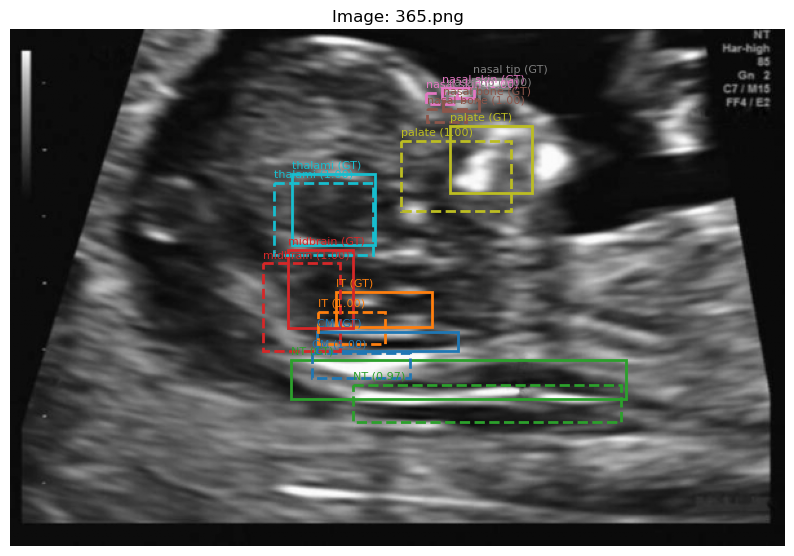

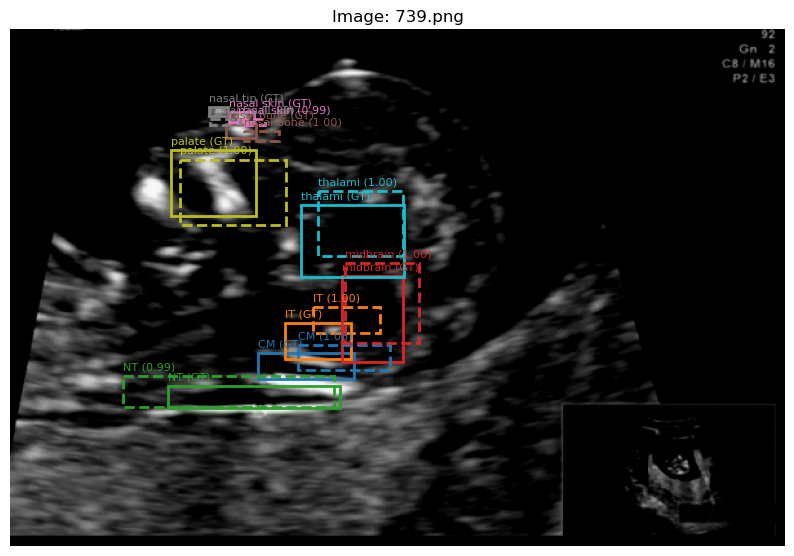

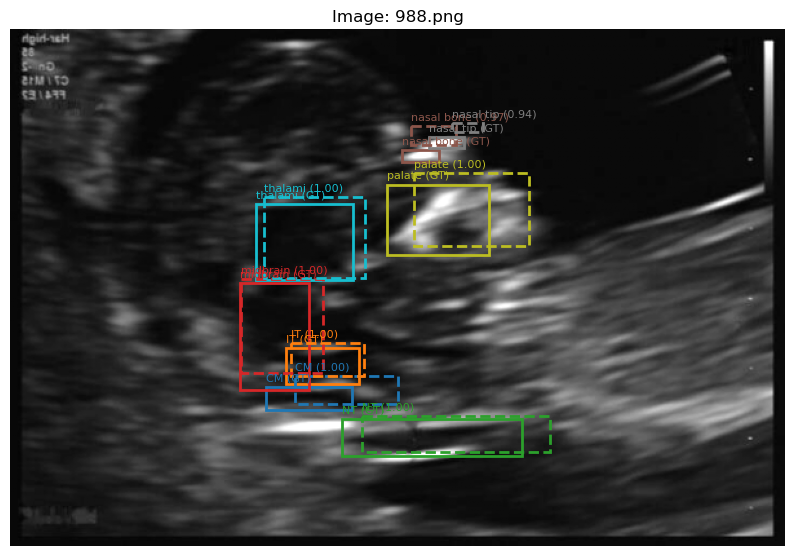

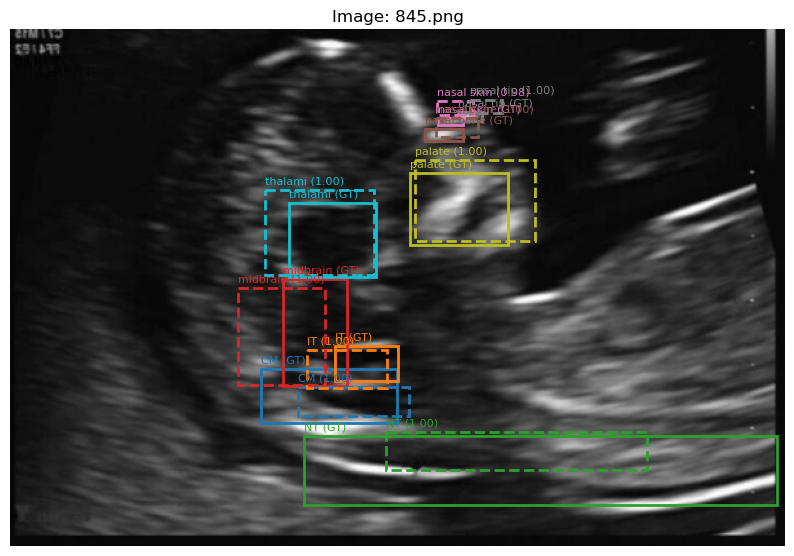

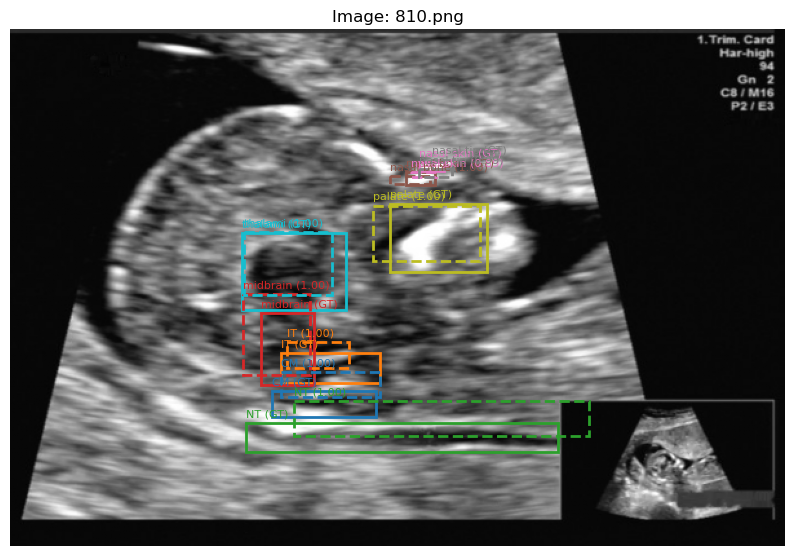

In [21]:
for i in range(5):  # Visualize 5 predictions
    visualize_prediction(model, val_ds, idx=i, threshold=0.3)

In [20]:
# Save model as .onnx
def save_model_onnx(model, filename="anatomy_detector.onnx", input_shape=(1, 1, TARGET_HEIGHT, TARGET_WIDTH)):
    model.eval()
    dummy_input = torch.randn(input_shape).cuda()
    
    torch.onnx.export(model, dummy_input, filename,
                      input_names=['input'],
                      output_names=['class_probs', 'boxes'],
                      dynamic_axes={
                          'input': {0: 'batch_size'},
                          'class_probs': {0: 'batch_size'},
                          'boxes': {0: 'batch_size'}
                      },
                      opset_version=12)
    print(f"Model saved to {filename}")

# save_model_onnx(model, filename="anatomy_detector.onnx", input_shape=(1, 1, TARGET_HEIGHT, TARGET_WIDTH))
